# Robot baseball

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize as opt

## 1. 2x2 zero-sum games

We first consider a general two-player, zero-sum game with payoff matrix
$$
\begin{pmatrix}
A & B \\
C & D
\end{pmatrix}.
$$

In this game:
- player A selects a row and receives the payoff indicated in the resulting matrix entry, and 
- player B selects a column and receives the negative of that payoff. 

The players choose their actions simultaneously and independently, each without observing the other's choice.

A **saddle point** is an entry in the payoff matrix that is simultaneously:
- *maximal within its column*, so player A cannot improve by switching rows, and  
- *minimal within its row*, so player B cannot improve by switching columns.

Such an entry exists iff
$$
\max(\min(A, B), \min(C, D))
=
\min(\max(A, C), \max(B, D)).
$$

When this condition holds, the corresponding action pair is a **pure strategy** that constitutes a Nash equilibrium, since neither player can improve by unilaterally deviating.

In [2]:
def best_pure(A, B, C, D):
    """
    This method assumes a pure strategy exists
    x = 1.0 if player A's equilibrium move is the first row, 0.0 otherwise
    y = 1.0 if player B's equilibrium move is the first column, 0.0 otherwise
    value is the value of the game at the pure strategy 
    """
    x = min(A, B) >= min(C, D)
    y = max(A, C) <= max(B, D)
    value = max(min(A, B), min(C, D))
    
    return float(x), float(y), value

In a **mixed strategy**: 
- player A selects the first row with probability $x$ and the second with probability $1 - x$, and
- layer B selects the first column with probability $y$ and the second with probability $1 - y$.

At a Nash equilibrium, each player must make the opponent indifferent between their available actions. For player A, this means that the expected payoff of each column should be equal,
$$
x A + (1 - x) C = x B + (1 - x) D,
$$
which yields
$$
x = \frac{D - C}{A - B - C + D}.
$$
For player B, this means that the expected payoff of each row should be equal, so by symmetry,
$$
y = \frac{D - B}{A - B - C + D}.
$$

When both players use these probabilities, the expected payoff for player A is
$$
\begin{align*}
EX &= x y A + (1 - x) y B + x (1 - y) C + (1 - x) (1 - y) D = \frac{AD - BC}{A - B - C + D}.
\end{align*}
$$

A valid mixed-strategy equilibrium requires $x, y \in [0,1]$. This occurs precisely when the players’ incentives cross, that is, when one row is better against one column and worse against the other (equivalently, when either $A,D < B,C$ or $B,C < A,D$). In such cases, no pure strategy is stable, and only randomization produces a Nash equilibrium.

In [3]:
def best_mixed(A, B, C, D):
    den = A - B - C + D
    if den == 0:
        return best_pure(A, B, C, D)

    x = (D - C) / den
    y = (D - B) / den
    value = (A * D - B * C) / den

    if not (0.0 <= x <= 1.0 and 0.0 <= y <= 1.0):
        return best_pure(A, B, C, D)

    return value, x, y

## 2. Computing $q$

For any given home-run probability $p$, we work backwards over all ball-strike counts. 

At each state $(b,s)$ we construct the payoff matrix for the batter's *wait vs. swing* and the pitcher's *ball vs. strike* decisions, and record
- the expected points $W[b][s]$ from state $(b,s)$,
- the batter's equilibrium probability $x[b][s]$ of waiting, and
- the pitcher's equilibrium probability $y[b][s]$ of throwing a ball.


In [4]:
def compute_equilibrium(p):
    W = [[0.0] * 3 for _ in range(4)]
    x = [[0.0] * 3 for _ in range(4)]
    y = [[0.0] * 3 for _ in range(4)]

    for b in range(3, -1, -1):
        for s in range(2, -1, -1):

            A = 1.0 if b == 3 else W[b + 1][s]
            B = 0.0 if s == 2 else W[b][s + 1]
            C = 0.0 if s == 2 else W[b][s + 1]
            D = 4.0 * p if s == 2 else 4.0 * p + (1.0 - p) * W[b][s + 1]

            W[b][s], x[b][s], y[b][s] = best_mixed(A, B, C, D)

    return W, x, y

To compute the probability $q$ that an at-bat reaches a full count $(3,2)$, we define $R[b][s]$ as the probability of eventually reaching $(3,2)$ when the current state is $(b,s)$. We compute these values by backward induction, starting from the absorbing state $R[3][2] = 1$ and propagating through all other counts.

The quantity of interest is then $q = R[0][0]$.

In [5]:
def hitting_probability(p, m=3, n=2):
    _, x, y = compute_equilibrium(p)
    R = [[0.0] * (n + 1) for _ in range(m + 1)]
    R[m][n] = 1.0

    for b in range(m, -1, -1):
        for s in range(n, -1, -1):
            if (b, s) == (m, n):
                continue

            xbs = x[b][s]
            ybs = y[b][s]

            p_ball = xbs * ybs
            p_strike = xbs * (1 - ybs) + (1 - xbs) * ybs + (1 - xbs) * (1 - ybs) * (1 - p)

            nxt_ball = R[b + 1][s] if b < m else 0
            nxt_strike = R[b][s + 1] if s < n else 0

            R[b][s] = p_ball * nxt_ball + p_strike * nxt_strike

    return R[0][0]

## 3. Optimizing $p$

Finally, we maximize $q(p)$.

In [6]:
EPS = 1e-15
p_star = opt.golden(lambda p: -hitting_probability(p), brack=(0.0, 0.5, 1.0), tol=EPS)
q_star = hitting_probability(p_star)

print(f"p* = {p_star}")
print(f"q* = {q_star}")

p* = 0.22697322801041941
q* = 0.29596799337427215


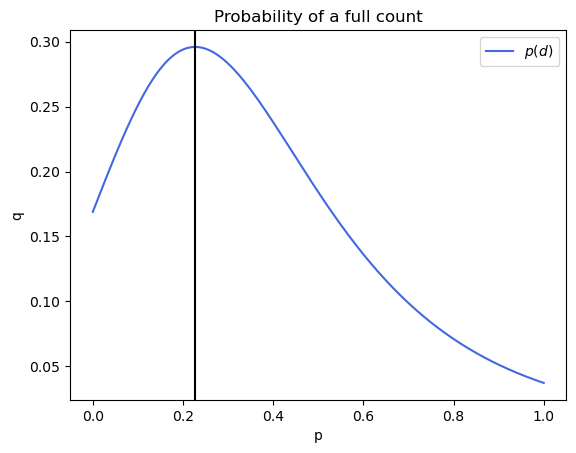

In [7]:
xs = np.linspace(1e-4, 1 - 1e-4, 800)
ys = [hitting_probability(p) for p in xs]

plt.plot(xs, ys, color="royalblue", label=r"$p(d)$")
plt.axvline(p_star, color="black")
plt.title("Probability of a full count")
plt.xlabel("p")
plt.ylabel("q")
plt.legend()
plt.show()

## 4. Hitting probabilities

We can compute the hitting probabilities of each state.

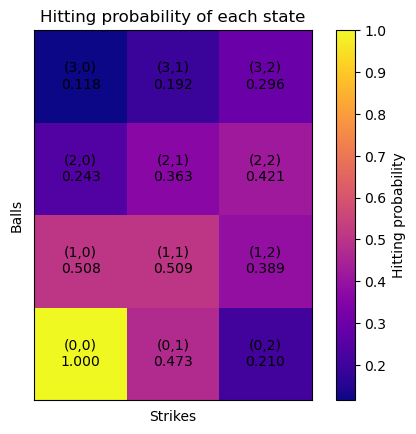

In [8]:
heat = np.array([[hitting_probability(p_star, b, s) for s in range(3)] for b in range(4)])
plt.imshow(heat, origin="lower", cmap="plasma")
plt.colorbar(label="Hitting probability")

for b in range(4):
    for s in range(3):
        plt.text(s, b, f"({b},{s})\n{heat[b,s]:.3f}", ha="center", va="center")

plt.xlabel("Strikes")
plt.ylabel("Balls")
plt.title("Hitting probability of each state")
plt.xticks([])
plt.yticks([])
plt.show()


# 5. Absorbing probabilities

We can also compute the probabilities for each outcome of the game.

In [9]:
def strikeout_probability(p):
    _, x, y = compute_equilibrium(p)
    R = [[0.0] * 3 for _ in range(4)]

    for b in range(3, -1, -1):
        for s in range(2, -1, -1):
            xbs = x[b][s]
            ybs = y[b][s]

            p_ball = xbs * ybs
            p_strike = xbs * (1 - ybs) + (1 - xbs) * ybs + (1 - xbs) * (1 - ybs) * (1 - p)

            nxt_ball = R[b + 1][s] if b < 3 else 0
            nxt_strike = 1 if s == 2 else R[b][s + 1]

            R[b][s] = p_ball * nxt_ball + p_strike * nxt_strike

    return R[0][0]

In [10]:
def walk_probability(p):
    _, x, y = compute_equilibrium(p)
    R = [[0.0] * 3 for _ in range(4)]

    for b in range(3, -1, -1):
        for s in range(2, -1, -1):
            xbs = x[b][s]
            ybs = y[b][s]

            p_ball = xbs * ybs
            p_strike = xbs * (1 - ybs) + (1 - xbs) * ybs + (1 - xbs) * (1 - ybs) * (1 - p)

            nxt_ball = 1 if b == 3 else R[b + 1][s]
            nxt_strike = R[b][s + 1] if s < 2 else 0

            R[b][s] = p_ball * nxt_ball + p_strike * nxt_strike

    return R[0][0]

In [11]:
def homerun_probability(p):
    _, x, y = compute_equilibrium(p)
    R = [[0.0] * 3 for _ in range(4)]

    for b in range(3, -1, -1):
        for s in range(2, -1, -1):
            xbs = x[b][s]
            ybs = y[b][s]

            p_ball = xbs * ybs
            p_strike = xbs * (1 - ybs) + (1 - xbs) * ybs + (1 - xbs) * (1 - ybs) * (1 - p)

            nxt_ball = 0 if b == 3 else R[b + 1][s]
            nxt_strike = 0 if s == 2 else R[b][s + 1]

            R[b][s] = p_ball * nxt_ball + p_strike * nxt_strike + (1 - xbs) * (1 - ybs) * p

    return R[0][0]

In [12]:
qS = strikeout_probability(p_star)
qW = walk_probability(p_star)
qHR = homerun_probability(p_star)

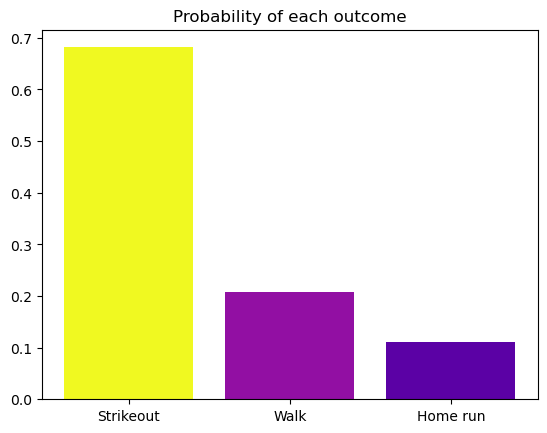

In [13]:
labels = ["Strikeout", "Walk", "Home run"]
values = np.array([qS, qW, qHR])
colors = cm.plasma(values / values.max())

plt.bar(labels, values, color=colors)
plt.title("Probability of each outcome")
plt.show()

Finally, we can compute the slash line.

In [14]:
batting_avg = qHR / (qS + qHR)
onbase_perc = qW + qHR
slugging_avg = 4 * batting_avg

batting_avg, onbase_perc, slugging_avg

(0.13900418938768083, 0.31825059309068987, 0.5560167575507233)